### mLight - 스마트폰으로 측정한 주변 빛 

In [2]:
from datetime import datetime

# 현재 날짜 및 시간 가져오기
now = datetime.now()
timestamp = now.strftime("%m%d_%H%M")  # 예: 0517_1530

# kmjng
# submission_folder = '/home/user/miniconda3/envs/gpu_conda/src/lifelog-sleep-ictc-2025/minjeong/submission/'

# # kmjng-nb
submission_folder = 'C:/Users/minjeong/Documents/my_env/env1/src/lifelog-sleep-ictc-2025/minjeong/submission'

submission_file = f'submission_final_mod3_1_{timestamp}.csv'

# kmjng
# base_folder =  '/home/user/miniconda3/envs/gpu_conda/src/data/ETRI_lifelog_dataset'

# # kmjng-nb
base_folder = 'C:/Users/minjeong/Documents/my_env/env1/src/data/ETRI_lifelog_dataset'

folder = '/ch2025_data_items'

data_dir = base_folder + folder 


import numpy as np 
import pandas as pd 
import glob 
import random 
import os 




# Parquet 파일 전체 경로 리스트 
parquet_files = glob.glob(os.path.join(data_dir, 'ch2025_*.parquet')) 

# 파일 이름을 키로, DataFrame을 값으로 저장할 딕셔너리 
lifelog_data = {} 

# 파일별로 읽기 
for file_path in parquet_files: 
    name = os.path.basename(file_path).replace('.parquet', '').replace('ch2025_', '') 
    lifelog_data[name] = pd.read_parquet(file_path) 
    print(f"✅ Loaded: {name}, shape = {lifelog_data[name].shape}") 

# 딕셔너리에 있는 모든 항목을 독립적인 변수로 할당 
for key, df in lifelog_data.items(): 
    globals()[f"{key}_df"] = df 

# 메트릭스 파일 읽기
metrics_train = pd.read_csv(base_folder + '/ch2025_metrics_train.csv')
sample_submission = pd.read_csv(base_folder+'/ch2025_submission_sample.csv')

# ✅ 기준 쌍 (subject_id, lifelog_date) 
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date']) 
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date)) 

# --------------------------- # 
# ✅ DataFrame 별 timestamp 컬럼 수동 지정 
dataframes = { 
    'mACStatus': (mACStatus_df, 'timestamp'), 
    'mActivity': (mActivity_df, 'timestamp'), 
    'mAmbience': (mAmbience_df, 'timestamp'), 
    'mBle': (mBle_df, 'timestamp'), 
    'mGps': (mGps_df, 'timestamp'), 
    'mLight': (mLight_df, 'timestamp'), 
    'mScreenStatus': (mScreenStatus_df, 'timestamp'), 
    'mUsageStats': (mUsageStats_df, 'timestamp'), 
    'mWifi': (mWifi_df, 'timestamp'), 
    'wHr': (wHr_df, 'timestamp'), 
    'wLight': (wLight_df, 'timestamp'), 
    'wPedo': (wPedo_df, 'timestamp'), 
} 
# ✅ 분리 함수 
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'): 
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce') 
    df = df.dropna(subset=[timestamp_col]) 
    df['date_only'] = df[timestamp_col].dt.date 
    df['key'] = list(zip(df[subject_col], df['date_only'])) 
    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    return test_df, train_df 


# ✅ 결과 저장 
for name, (df, ts_col) in dataframes.items(): 
    print(f"⏳ {name} 분리 중...") 
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col) 
    globals()[f"{name}_test"] = test_df 
    globals()[f"{name}_train"] = train_df 
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}") 

✅ Loaded: mACStatus, shape = (939896, 3)
✅ Loaded: mActivity, shape = (961062, 3)
✅ Loaded: mAmbience, shape = (476577, 3)
✅ Loaded: mBle, shape = (21830, 3)
✅ Loaded: mGps, shape = (800611, 3)
✅ Loaded: mLight, shape = (96258, 3)
✅ Loaded: mScreenStatus, shape = (939653, 3)
✅ Loaded: mUsageStats, shape = (45197, 3)
✅ Loaded: mWifi, shape = (76336, 3)
✅ Loaded: wHr, shape = (382918, 3)
✅ Loaded: wLight, shape = (633741, 3)
✅ Loaded: wPedo, shape = (748100, 9)
⏳ mACStatus 분리 중...
✅ mACStatus_test → (335849, 3), mACStatus_train → (604047, 3)
⏳ mActivity 분리 중...
✅ mActivity_test → (343579, 3), mActivity_train → (617483, 3)
⏳ mAmbience 분리 중...
✅ mAmbience_test → (170453, 3), mAmbience_train → (306124, 3)
⏳ mBle 분리 중...
✅ mBle_test → (8140, 3), mBle_train → (13690, 3)
⏳ mGps 분리 중...
✅ mGps_test → (287386, 3), mGps_train → (513225, 3)
⏳ mLight 분리 중...
✅ mLight_test → (34439, 3), mLight_train → (61819, 3)
⏳ mScreenStatus 분리 중...
✅ mScreenStatus_test → (336160, 3), mScreenStatus_train → (60349

In [10]:
mLight_df.head(10)

,subject_id,timestamp,m_light
0,id01,2024-06-26 12:03:00,534.0
1,id01,2024-06-26 12:13:00,846.0
2,id01,2024-06-26 12:23:00,826.0
3,id01,2024-06-26 12:33:00,851.0
4,id01,2024-06-26 12:43:00,428.0
5,id01,2024-06-26 12:53:00,306.0
6,id01,2024-06-26 13:03:00,482.0
7,id01,2024-06-26 13:13:00,1586.0
8,id01,2024-06-26 13:23:00,1208.0
9,id01,2024-06-26 13:33:00,1403.0


In [5]:
def process_mLight(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    df['hour'] = df['timestamp'].dt.hour 
    # 밤(22~05시), 낮(06~21시) 구분 
    df['is_night'] = df['hour'].apply(lambda h: h >= 22 or h < 6) 
    # 하루 단위 요약 
    daily = df.groupby(['subject_id', 'date']).agg( 
        light_mean=('m_light', 'mean'), 
        light_std=('m_light', 'std'), 
        light_max=('m_light', 'max'), 
        light_min=('m_light', 'min'), 
        light_night_mean=('m_light', lambda x: x[df.loc[x.index, 'is_night']].mean()), 
        light_day_mean=('m_light', lambda x: x[~df.loc[x.index, 'is_night']].mean()), 
        light_night_ratio=('is_night', 'mean') # 밤 시간 측정 비율 
    ).reset_index() 
    return daily 

mLight_df2 = process_mLight(mLight_df) 

In [6]:
mLight_df2.head(2)

,subject_id,date,light_mean,light_std,light_max,light_min,light_night_mean,light_day_mean,light_night_ratio
0,id01,2024-06-26,364.506849,395.659440,1886.0,0.0,184.923077,403.416667,0.178082
1,id01,2024-06-27,332.069444,1300.535681,11248.0,0.0,27.708333,484.250000,0.333333


C:\Users\minjeong\AppData\Local\Temp\ipykernel_11472\2063594231.py:58: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\minjeong\AppData\Local\Temp\ipykernel_11472\2063594231.py:58: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\minjeong\AppData\Local\Temp\ipykernel_11472\2063594231.py:58: UserWarning: Glyph 45230 (\N{HANGUL SYLLABLE NAJ}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\minjeong\AppData\Local\Temp\ipykernel_11472\2063594231.py:58: UserWarning: Glyph 48164 (\N{HANGUL SYLLABLE BAM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\minjeong\Documents\my_env\env1\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\minjeong\Documents\my_env\env1\Lib\site-packages\IPython\co

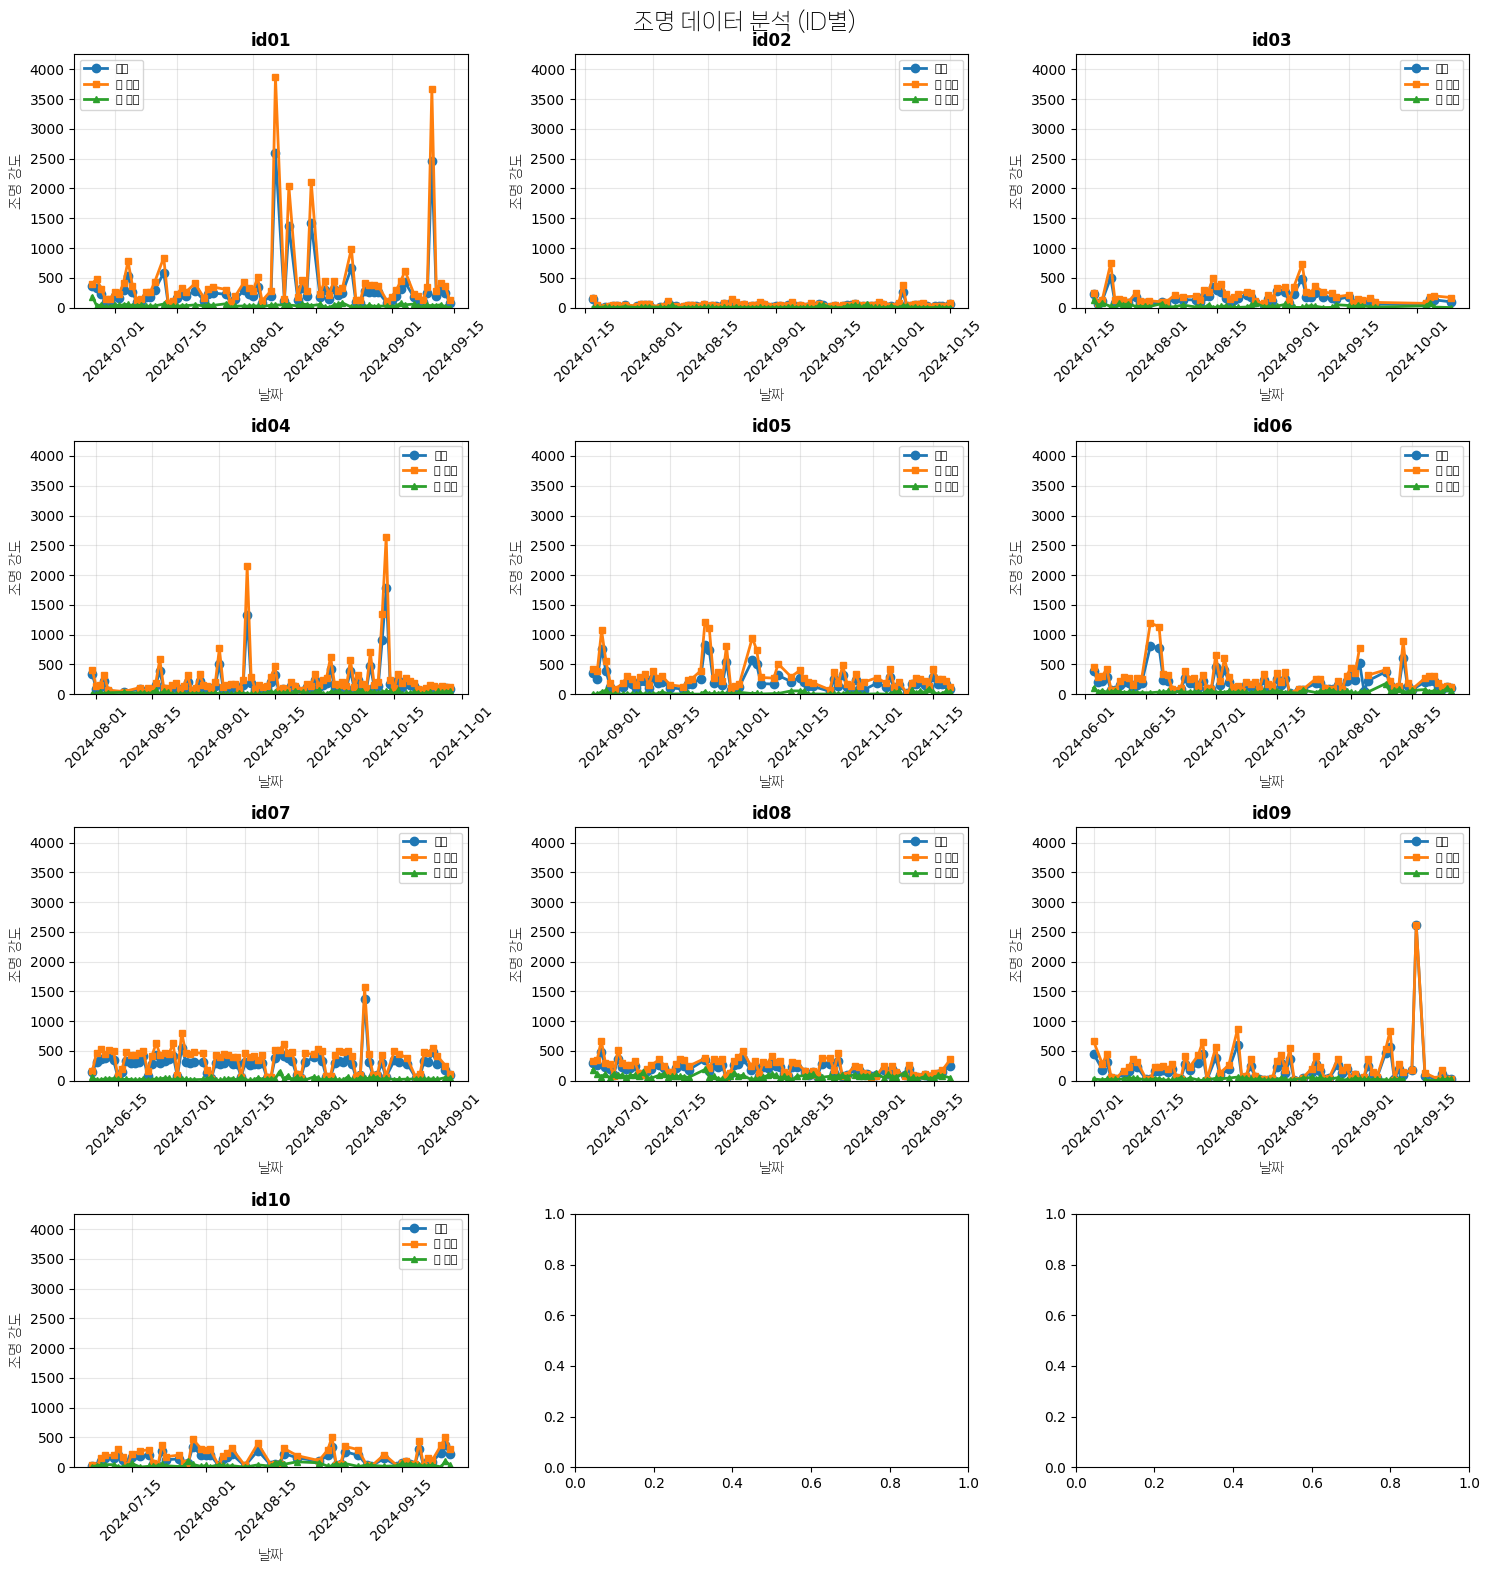

C:\Users\minjeong\AppData\Local\Temp\ipykernel_11472\2063594231.py:88: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\minjeong\AppData\Local\Temp\ipykernel_11472\2063594231.py:88: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\minjeong\AppData\Local\Temp\ipykernel_11472\2063594231.py:88: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\minjeong\AppData\Local\Temp\ipykernel_11472\2063594231.py:88: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\minjeong\AppData\Local\Temp\ipykernel_11472\2063594231.py:88: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\minjeong\AppData\Local\Temp\ipykernel_11472\2063594231.py:88: UserWarning: Glyph 46020 (\N{HANGUL SYLLA

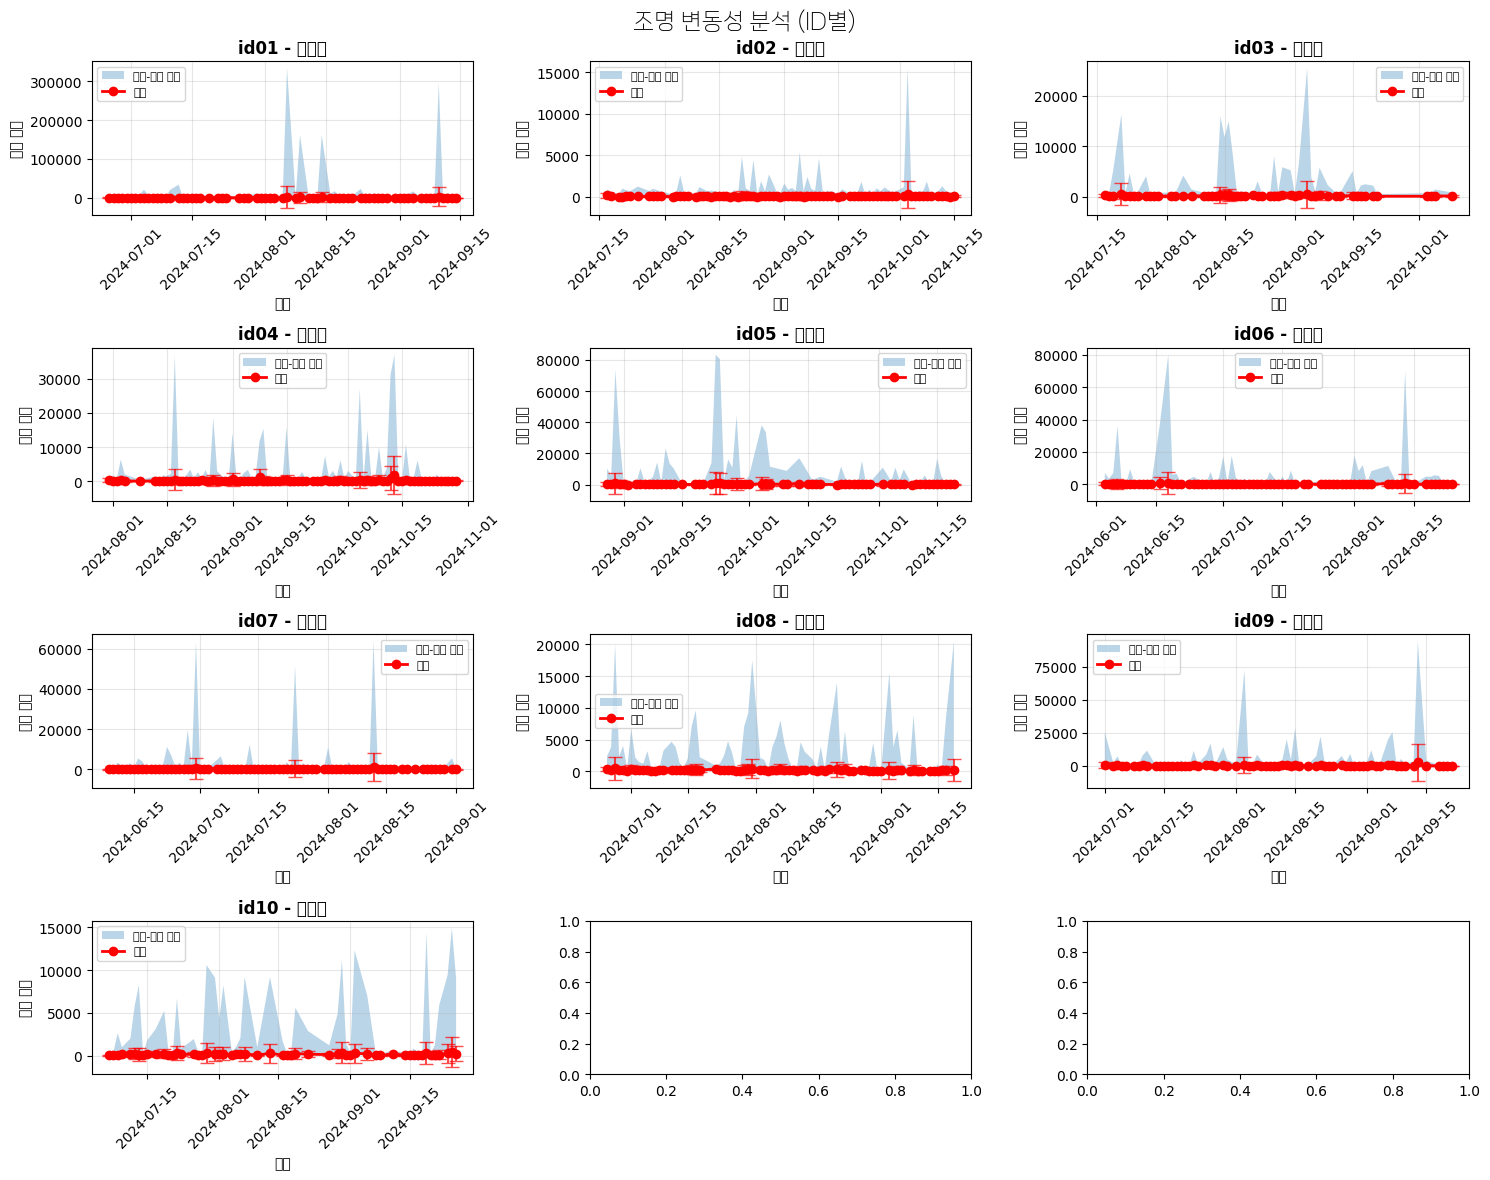

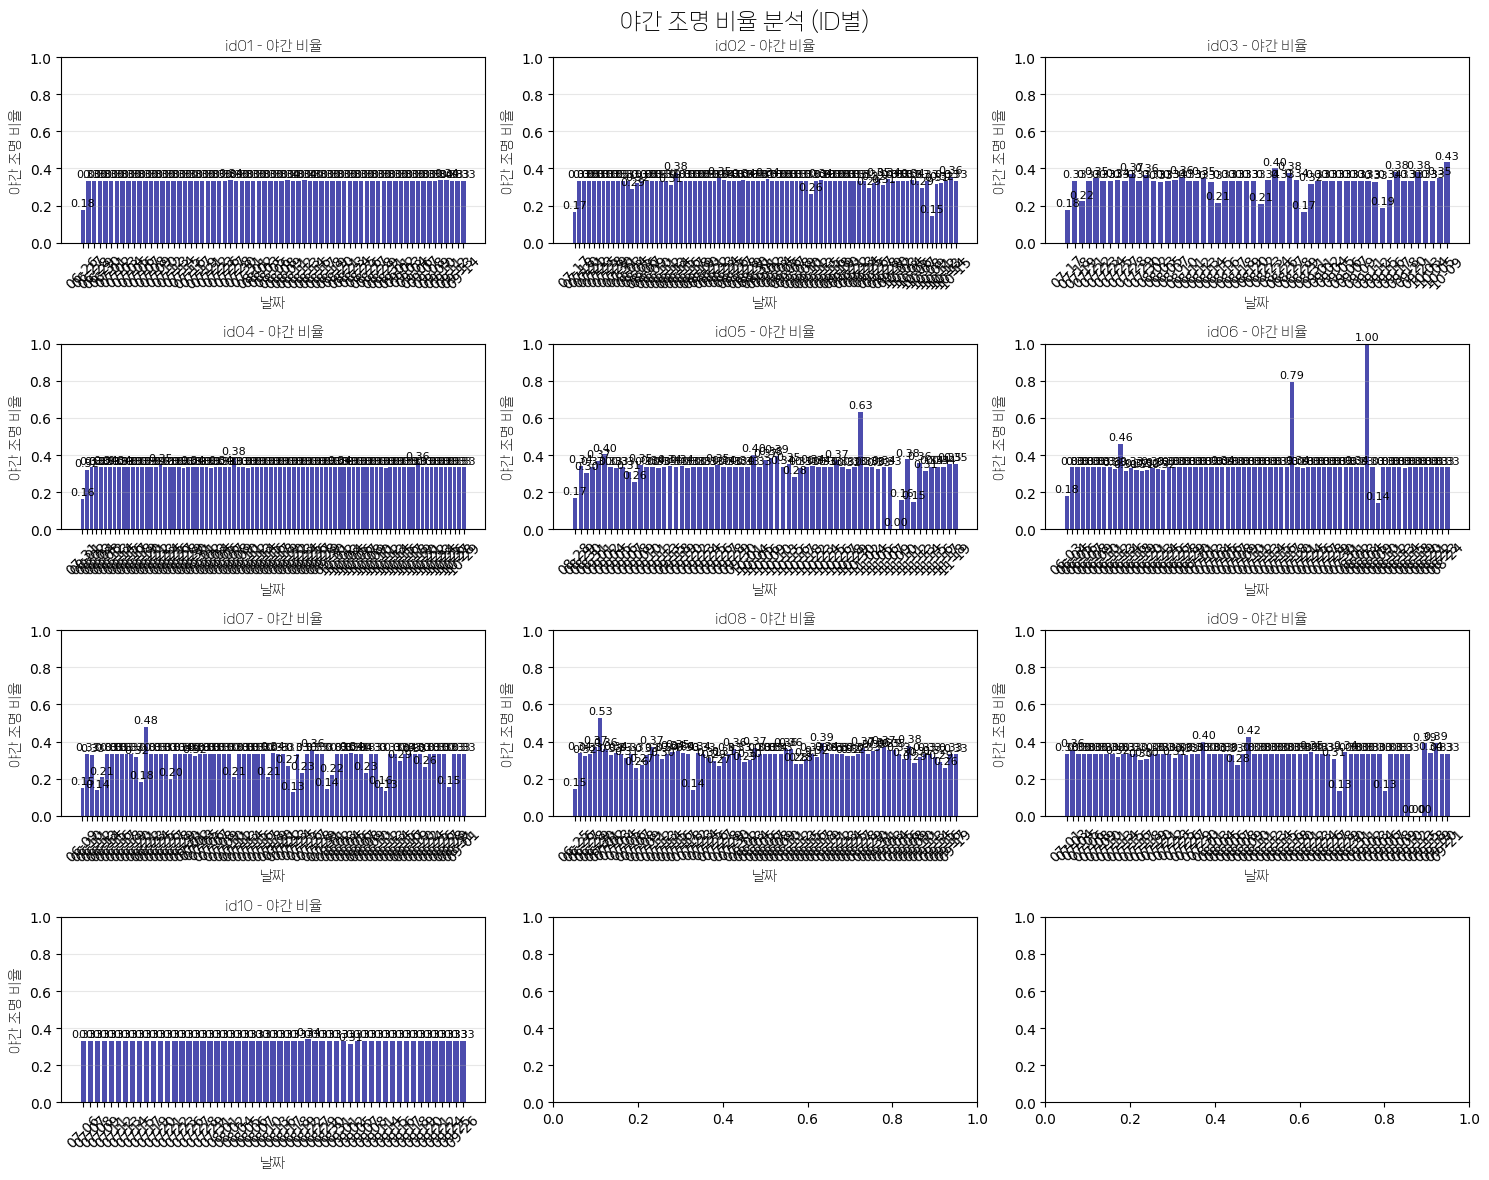

시각화 완료!
총 10개 ID의 데이터를 분석했습니다.
생성된 그래프:
1. 조명 데이터 분석: 평균, 낮 평균, 밤 평균 비교
2. 조명 변동성 분석: 표준편차와 최대/최소 범위
3. 야간 조명 비율 분석: ID별 야간 조명 비율 비교


In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib.font_manager as fm

# 나눔고딕 폰트 경로 설정
# font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_path = r'C:\Users\minjeong\AppData\Local\Microsoft\Windows\Fonts\NanumSquareNeo-aLt.ttf'
font_prop = fm.FontProperties(fname=font_path)
#

# 샘플 데이터 생성 (실제 데이터로 교체하세요)
data = mLight_df2.copy()

# DataFrame 생성
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])

# 고유한 ID 리스트 가져오기
unique_ids = sorted(df['subject_id'].unique())

# subplot 설정 (3x3 그리드)
fig, axes = plt.subplots(4, 3, figsize=(15, 16))  # 4행 3열로 변경, 높이도 좀 늘림
fig.suptitle('조명 데이터 분석 (ID별)', fontsize=16, fontweight='bold' ,fontproperties=font_prop)

# 각 ID별로 그래프 그리기
for i, subject_id in enumerate(unique_ids):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    
    # 해당 ID의 데이터 필터링
    id_data = df[df['subject_id'] == subject_id].sort_values('date')
    
    # 날짜를 x축으로 설정
    dates = id_data['date']
    
    # 여러 조명 지표를 한 그래프에 표시
    ax.plot(dates, id_data['light_mean'], 'o-', label='평균', linewidth=2, markersize=6)
    ax.plot(dates, id_data['light_day_mean'], 's-', label='낮 평균', linewidth=2, markersize=5)
    ax.plot(dates, id_data['light_night_mean'], '^-', label='밤 평균', linewidth=2, markersize=5)
    
    # 그래프 설정
    ax.set_title(f'{subject_id}', fontweight='bold')
    ax.set_xlabel('날짜' ,fontproperties=font_prop)
    ax.set_ylabel('조명 강도' ,fontproperties=font_prop)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # x축 날짜 형식 설정
    ax.tick_params(axis='x', rotation=45)
    
    # y축 범위 설정 (모든 subplot에서 동일한 범위 사용)
    ax.set_ylim(0, max(df['light_day_mean']) * 1.1)

# 레이아웃 조정
plt.tight_layout()
plt.show()

# 추가: 더 자세한 분석을 위한 별도 시각화
fig2, axes2 = plt.subplots(4, 3, figsize=(15, 12))
fig2.suptitle('조명 변동성 분석 (ID별)', fontsize=16, fontweight='bold',fontproperties=font_prop)

for i, subject_id in enumerate(unique_ids):
    row = i // 3
    col = i % 3
    ax = axes2[row, col]
    
    id_data = df[df['subject_id'] == subject_id].sort_values('date')
    dates = id_data['date']
    
    # 표준편차와 최대/최소값으로 변동성 표시
    ax.fill_between(dates, id_data['light_min'], id_data['light_max'], 
                    alpha=0.3, label='최대-최소 범위')
    ax.plot(dates, id_data['light_mean'], 'o-', color='red', 
            linewidth=2, markersize=6, label='평균')
    ax.errorbar(dates, id_data['light_mean'], yerr=id_data['light_std'], 
                fmt='none', color='red', alpha=0.7, capsize=5)
    
    ax.set_title(f'{subject_id} - 변동성', fontweight='bold')
    ax.set_xlabel('날짜')
    ax.set_ylabel('조명 강도')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 야간/주간 비율 비교
fig3, axes3 = plt.subplots(4, 3, figsize=(15, 12))
fig3.suptitle('야간 조명 비율 분석 (ID별)', fontsize=16, fontweight='bold' ,fontproperties=font_prop)

for i, subject_id in enumerate(unique_ids):
    row = i // 3
    col = i % 3
    ax = axes3[row, col]
    
    id_data = df[df['subject_id'] == subject_id].sort_values('date')
    dates = id_data['date']
    
    # 야간 비율 시각화
    bars = ax.bar(range(len(dates)), id_data['light_night_ratio'], 
                  color='darkblue', alpha=0.7)
    
    # 각 바 위에 값 표시
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_title(f'{subject_id} - 야간 비율', fontweight='bold' ,fontproperties=font_prop)
    ax.set_xlabel('날짜' ,fontproperties=font_prop)
    ax.set_ylabel('야간 조명 비율' ,fontproperties=font_prop)
    ax.set_xticks(range(len(dates)))
    ax.set_xticklabels([d.strftime('%m-%d') for d in dates], rotation=45)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("시각화 완료!")
print(f"총 {len(unique_ids)}개 ID의 데이터를 분석했습니다.")
print("생성된 그래프:")
print("1. 조명 데이터 분석: 평균, 낮 평균, 밤 평균 비교")
print("2. 조명 변동성 분석: 표준편차와 최대/최소 범위")
print("3. 야간 조명 비율 분석: ID별 야간 조명 비율 비교")

In [27]:
metrics_train.columns

Index(['subject_id', 'sleep_date', 'lifelog_date', 'Q1', 'Q2', 'Q3', 'S1',
       'S2', 'S3'],
      dtype='object')

🔄 조도 데이터 전처리 중...
✅ 조도 데이터 처리 완료: (450, 9)
🔄 타겟 데이터와 병합 중...
✅ 데이터 병합 완료: (450, 10)
📊 시각화 생성 중...


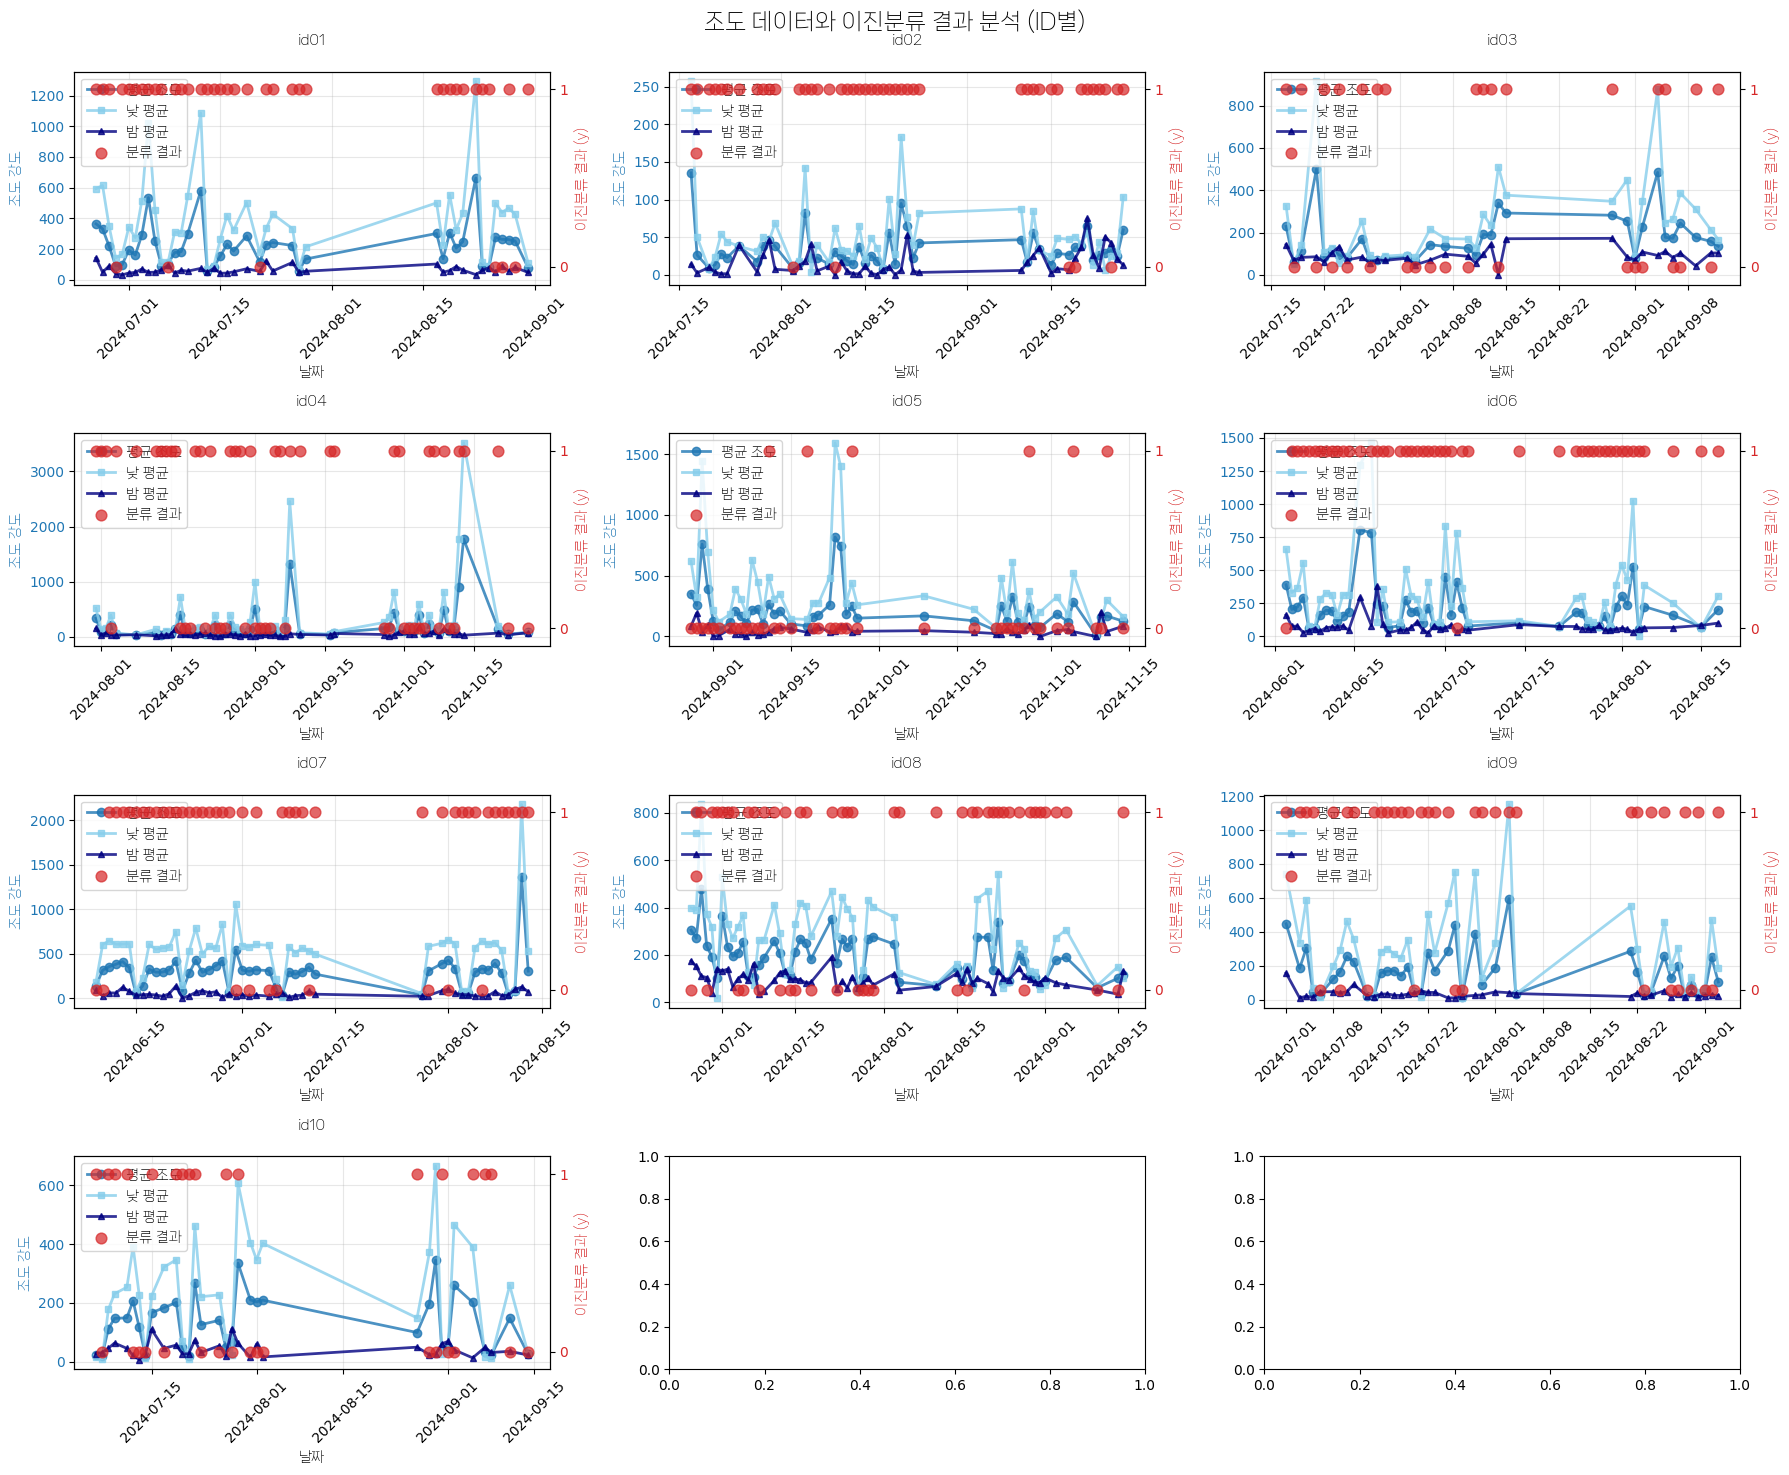

📈 상관관계 분석 중...


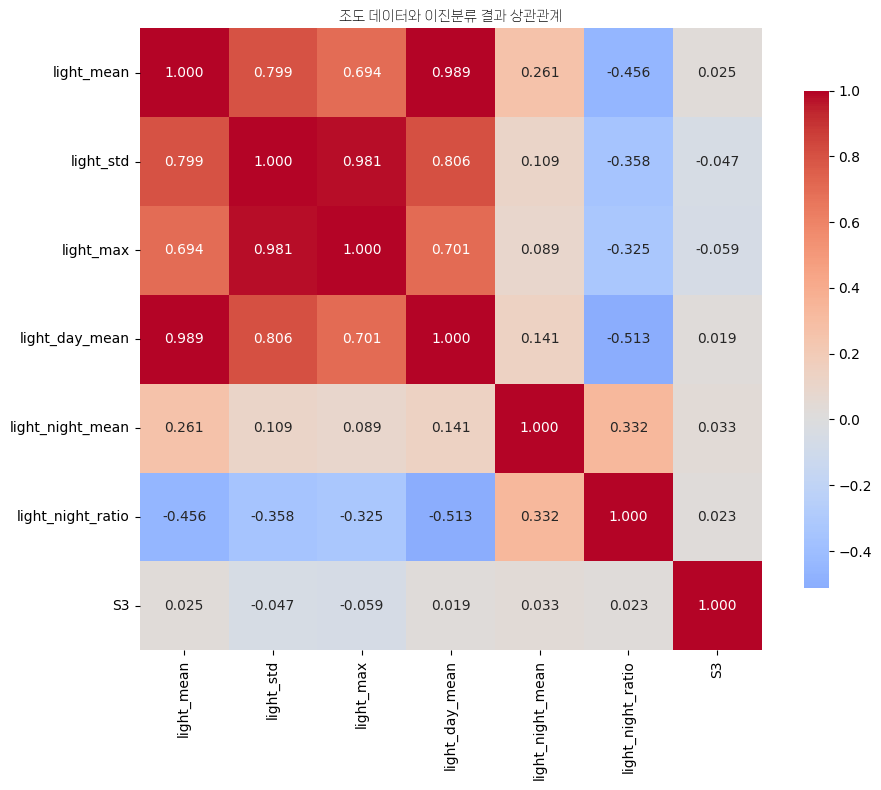

이진분류 결과(y)와의 상관관계:
  light_max: -0.059
  light_std: -0.047
  light_night_mean: 0.033
  light_mean: 0.025
  light_night_ratio: 0.023
  light_day_mean: 0.019
✅ 모든 시각화 완료!


In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from matplotlib import font_manager

# 이미 선언한 폰트 경로 사용
# font_prop = font_manager.FontProperties(fname='폰트경로.ttf')

Y = 'S3' # 

def preprocess_light_data(mLight_df):
    mLight_df['timestamp'] = pd.to_datetime(mLight_df['timestamp'])
    mLight_df['date'] = mLight_df['timestamp'].dt.date
    mLight_df['hour'] = mLight_df['timestamp'].dt.hour
    mLight_df['is_day'] = (mLight_df['hour'] >= 6) & (mLight_df['hour'] < 18)

    daily_light = mLight_df.groupby(['subject_id', 'date']).agg({
        'm_light': ['mean', 'std', 'max', 'min']
    }).round(2)
    daily_light.columns = ['light_mean', 'light_std', 'light_max', 'light_min']

    day_light = mLight_df[mLight_df['is_day']].groupby(['subject_id', 'date'])['m_light'].mean()
    night_light = mLight_df[~mLight_df['is_day']].groupby(['subject_id', 'date'])['m_light'].mean()

    daily_light['light_day_mean'] = day_light
    daily_light['light_night_mean'] = night_light
    daily_light['light_night_ratio'] = daily_light['light_night_mean'] / daily_light['light_mean']
    daily_light = daily_light.fillna(0)

    return daily_light.reset_index()

def merge_light_with_target(light_data, metrics_train):
    target_data = metrics_train[['subject_id', 'lifelog_date', f'{Y}']].copy()
    target_data['lifelog_date'] = pd.to_datetime(target_data['lifelog_date']).dt.date
    target_data = target_data.rename(columns={'lifelog_date': 'date'})
    merged_data = pd.merge(light_data, target_data, on=['subject_id', 'date'], how='inner')
    merged_data['date'] = pd.to_datetime(merged_data['date'])
    return merged_data

def create_dual_axis_visualization(merged_data):
    unique_ids = sorted(merged_data['subject_id'].unique())
    fig, axes = plt.subplots(4, 3, figsize=(18, 15))
    fig.suptitle('조도 데이터와 이진분류 결과 분석 (ID별)', fontsize=16, fontweight='bold', fontproperties=font_prop)

    for i, subject_id in enumerate(unique_ids[:10]):
        row = i // 3
        col = i % 3
        ax1 = axes[row, col]

        id_data = merged_data[merged_data['subject_id'] == subject_id].sort_values('date')

        if len(id_data) == 0:
            ax1.text(0.5, 0.5, f'{subject_id}\n데이터 없음', 
                     ha='center', va='center', transform=ax1.transAxes, fontsize=12)
            continue

        dates = id_data['date']
        color1 = 'tab:blue'
        ax1.set_xlabel('날짜', fontproperties=font_prop)
        ax1.set_ylabel('조도 강도', color=color1, fontproperties=font_prop)

        ax1.plot(dates, id_data['light_mean'], 'o-', color=color1, linewidth=2, markersize=6, label='평균 조도', alpha=0.8)
        ax1.plot(dates, id_data['light_day_mean'], 's-', color='skyblue', linewidth=2, markersize=5, label='낮 평균', alpha=0.8)
        ax1.plot(dates, id_data['light_night_mean'], '^-', color='navy', linewidth=2, markersize=5, label='밤 평균', alpha=0.8)

        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)

        ax2 = ax1.twinx()
        color2 = 'tab:red'
        ax2.set_ylabel('이진분류 결과 (y)', color=color2, fontproperties=font_prop)

        # 점 그래프로 변경
        ax2.scatter(dates, id_data[f'{Y}'], color=color2, alpha=0.7, label='분류 결과', s=60)

        ax2.tick_params(axis='y', labelcolor=color2)
        ax2.set_ylim(-0.1, 1.1)
        ax2.set_yticks([0, 1])
        ax2.set_yticklabels(['0', '1'])

        ax1.set_title(f'{subject_id}', fontweight='bold', pad=20, fontproperties=font_prop)

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8, prop=font_prop)

    for i in range(len(unique_ids), 10):
        row = i // 3
        col = i % 3
        axes[row, col].set_visible(False)

    plt.tight_layout()
    plt.show()

def analyze_correlation(merged_data):
    correlation_cols = ['light_mean', 'light_std', 'light_max', 'light_day_mean', 
                        'light_night_mean', 'light_night_ratio', f'{Y}']
    corr_matrix = merged_data[correlation_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
    plt.title('조도 데이터와 이진분류 결과 상관관계', fontsize=14, fontweight='bold', fontproperties=font_prop)
    plt.tight_layout()
    plt.show()

    y_correlations = corr_matrix[f'{Y}'].drop(f'{Y}').sort_values(key=abs, ascending=False)
    print("이진분류 결과(y)와의 상관관계:")
    for feature, corr in y_correlations.items():
        print(f"  {feature}: {corr:.3f}")

def main_visualization():
    print("🔄 조도 데이터 전처리 중...")
    try:
        light_processed = preprocess_light_data(mLight_train)
        print(f"✅ 조도 데이터 처리 완료: {light_processed.shape}")
    except NameError:
        print("⚠️  mLight_train 데이터가 없어 샘플 데이터를 생성합니다.")
        light_processed = create_sample_light_data()

    print("🔄 타겟 데이터와 병합 중...")
    try:
        merged_data = merge_light_with_target(light_processed, metrics_train)
        print(f"✅ 데이터 병합 완료: {merged_data.shape}")
    except NameError:
        print("⚠️  metrics_train 데이터가 없어 샘플 타겟 데이터를 생성합니다.")
        merged_data = add_sample_target_data(light_processed)

    print("📊 시각화 생성 중...")
    create_dual_axis_visualization(merged_data)

    print("📈 상관관계 분석 중...")
    analyze_correlation(merged_data)

    return merged_data

def create_sample_light_data():
    np.random.seed(42)
    dates = pd.date_range('2024-06-01', '2024-06-30', freq='D')
    ids = [f'id{i:02d}' for i in range(1, 10)]
    data = []

    for subject_id in ids:
        for date in dates[:10]:
            data.append({
                'subject_id': subject_id,
                'date': date.date(),
                'light_mean': np.random.normal(300, 100),
                'light_std': np.random.normal(200, 50),
                'light_max': np.random.normal(1500, 300),
                'light_min': 0,
                'light_day_mean': np.random.normal(400, 80),
                'light_night_mean': np.random.normal(50, 20),
                'light_night_ratio': np.random.uniform(0.1, 0.4)
            })

    return pd.DataFrame(data)

def add_sample_target_data(light_data):
    merged_data = light_data.copy()
    merged_data[f'{Y}'] = (merged_data['light_mean'] > merged_data['light_mean'].median()).astype(int)
    merged_data['date'] = pd.to_datetime(merged_data['date'])
    return merged_data

# 실행
if __name__ == "__main__":
    merged_data = main_visualization()
    print("✅ 모든 시각화 완료!")


### S1

🔄 조도 데이터 전처리 중...
✅ 조도 데이터 처리 완료: (450, 9)
🔄 타겟 데이터와 병합 중...
✅ 데이터 병합 완료: (450, 10)
📊 시각화 생성 중...


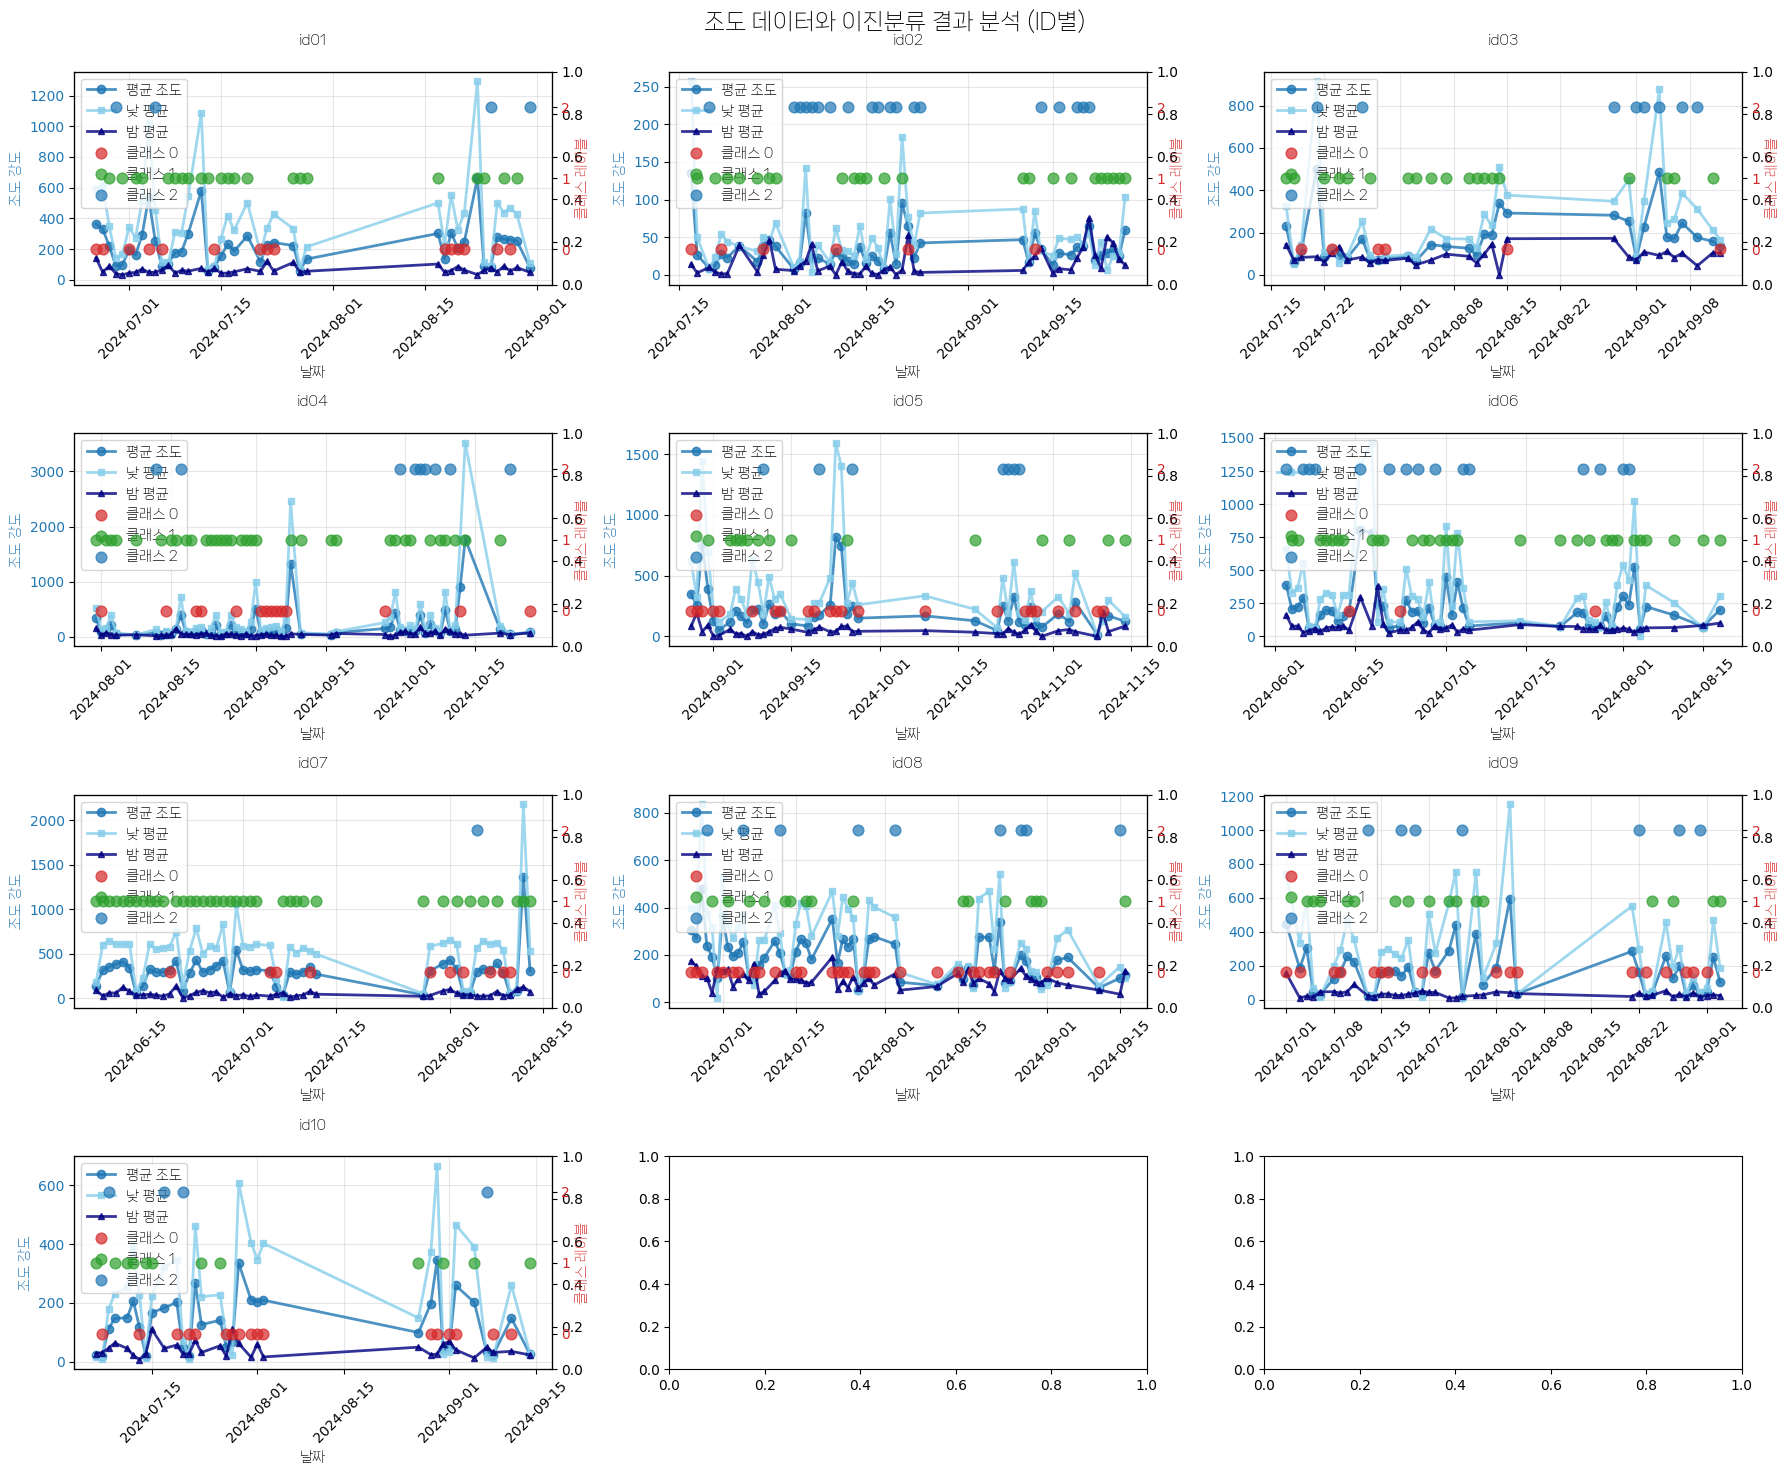

📈 상관관계 분석 중...


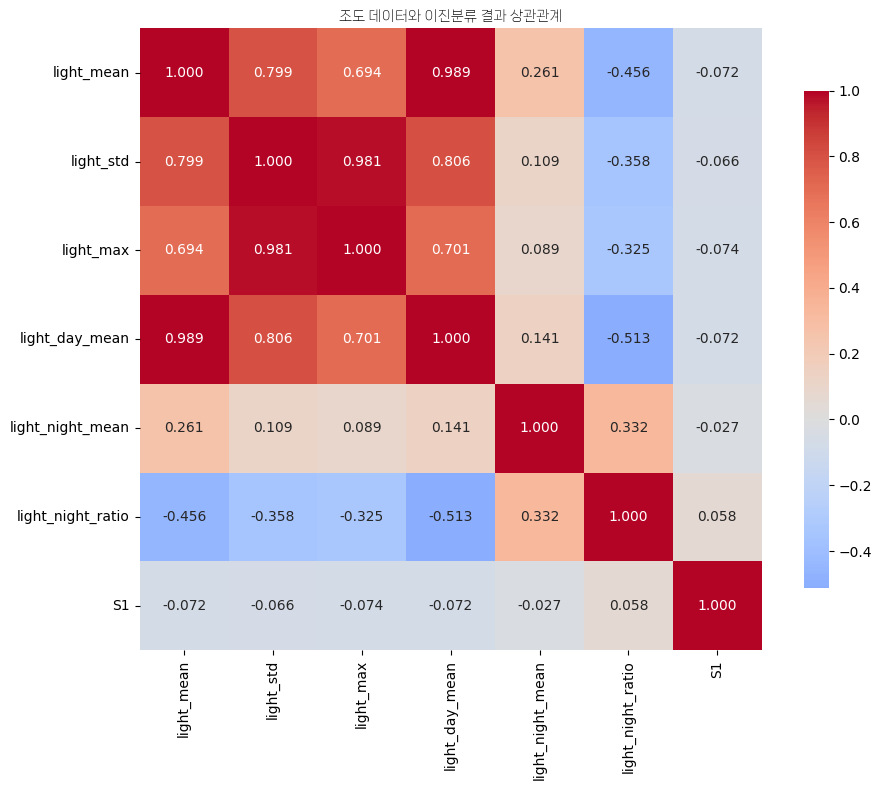

이진분류 결과(y)와의 상관관계:
  light_max: -0.074
  light_day_mean: -0.072
  light_mean: -0.072
  light_std: -0.066
  light_night_ratio: 0.058
  light_night_mean: -0.027
✅ 모든 시각화 완료!


In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import seaborn as sns
from matplotlib import font_manager

# 이미 선언한 폰트 경로 사용
# font_prop = font_manager.FontProperties(fname='폰트경로.ttf')

Y = 'S1' # 

def preprocess_light_data(mLight_df):
    mLight_df['timestamp'] = pd.to_datetime(mLight_df['timestamp'])
    mLight_df['date'] = mLight_df['timestamp'].dt.date
    mLight_df['hour'] = mLight_df['timestamp'].dt.hour
    mLight_df['is_day'] = (mLight_df['hour'] >= 6) & (mLight_df['hour'] < 18)

    daily_light = mLight_df.groupby(['subject_id', 'date']).agg({
        'm_light': ['mean', 'std', 'max', 'min']
    }).round(2)
    daily_light.columns = ['light_mean', 'light_std', 'light_max', 'light_min']

    day_light = mLight_df[mLight_df['is_day']].groupby(['subject_id', 'date'])['m_light'].mean()
    night_light = mLight_df[~mLight_df['is_day']].groupby(['subject_id', 'date'])['m_light'].mean()

    daily_light['light_day_mean'] = day_light
    daily_light['light_night_mean'] = night_light
    daily_light['light_night_ratio'] = daily_light['light_night_mean'] / daily_light['light_mean']
    daily_light = daily_light.fillna(0)

    return daily_light.reset_index()

def merge_light_with_target(light_data, metrics_train):
    target_data = metrics_train[['subject_id', 'lifelog_date', f'{Y}']].copy()
    target_data['lifelog_date'] = pd.to_datetime(target_data['lifelog_date']).dt.date
    target_data = target_data.rename(columns={'lifelog_date': 'date'})
    merged_data = pd.merge(light_data, target_data, on=['subject_id', 'date'], how='inner')
    merged_data['date'] = pd.to_datetime(merged_data['date'])
    return merged_data

def create_dual_axis_visualization(merged_data):
    unique_ids = sorted(merged_data['subject_id'].unique())
    fig, axes = plt.subplots(4, 3, figsize=(18, 15))
    fig.suptitle('조도 데이터와 이진분류 결과 분석 (ID별)', fontsize=16, fontweight='bold', fontproperties=font_prop)

    for i, subject_id in enumerate(unique_ids[:10]):
        row = i // 3
        col = i % 3
        ax1 = axes[row, col]

        id_data = merged_data[merged_data['subject_id'] == subject_id].sort_values('date')

        if len(id_data) == 0:
            ax1.text(0.5, 0.5, f'{subject_id}\n데이터 없음', 
                     ha='center', va='center', transform=ax1.transAxes, fontsize=12)
            continue

        dates = id_data['date']
        color1 = 'tab:blue'
        ax1.set_xlabel('날짜', fontproperties=font_prop)
        ax1.set_ylabel('조도 강도', color=color1, fontproperties=font_prop)

        ax1.plot(dates, id_data['light_mean'], 'o-', color=color1, linewidth=2, markersize=6, label='평균 조도', alpha=0.8)
        ax1.plot(dates, id_data['light_day_mean'], 's-', color='skyblue', linewidth=2, markersize=5, label='낮 평균', alpha=0.8)
        ax1.plot(dates, id_data['light_night_mean'], '^-', color='navy', linewidth=2, markersize=5, label='밤 평균', alpha=0.8)

        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.tick_params(axis='x', rotation=45)
        ax1.grid(True, alpha=0.3)

        ax2 = ax1.twinx()
        # color2 = 'tab:red'
        # ax2.set_ylabel('이진분류 결과 (y)', color=color2, fontproperties=font_prop)

        # # 점 그래프로 변경
        # ax2.scatter(dates, id_data[f'{Y}'], color=color2, alpha=0.7, label='분류 결과', s=60)

        # ax2.tick_params(axis='y', labelcolor=color2)
        # ax2.set_ylim(-0.1, 1.1)
        # ax2.set_yticks([0, 1])
        # ax2.set_yticklabels(['0', '1'])
        ax2 = ax1.twinx()
        color2 = 'tab:red'
        ax2.set_ylabel('클래스 레이블', color=color2, fontproperties=font_prop)

        # y의 클래스가 0,1,2일 경우: 색상별 점 찍기
        classes = sorted(id_data[f'{Y}'].unique())
        colors = ['tab:red', 'tab:green', 'tab:blue']
        color_map = dict(zip(classes, colors))

        for c in classes:
            class_data = id_data[id_data[f'{Y}'] == c]
            ax2.scatter(class_data['date'], class_data[f'{Y}'], color=color_map[c], alpha=0.7, s=60, label=f'클래스 {c}')

        ax2.tick_params(axis='y', labelcolor=color2)
        ax2.set_ylim(-0.5, 2.5)
        ax2.set_yticks([0, 1, 2])
        ax2.set_yticklabels(['0', '1', '2'])


        ax1.set_title(f'{subject_id}', fontweight='bold', pad=20, fontproperties=font_prop)

        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8, prop=font_prop)

    for i in range(len(unique_ids), 10):
        row = i // 3
        col = i % 3
        axes[row, col].set_visible(False)

    plt.tight_layout()
    plt.show()

def analyze_correlation(merged_data):
    correlation_cols = ['light_mean', 'light_std', 'light_max', 'light_day_mean', 
                        'light_night_mean', 'light_night_ratio', f'{Y}']
    corr_matrix = merged_data[correlation_cols].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
    plt.title('조도 데이터와 이진분류 결과 상관관계', fontsize=14, fontweight='bold', fontproperties=font_prop)
    plt.tight_layout()
    plt.show()

    y_correlations = corr_matrix[f'{Y}'].drop(f'{Y}').sort_values(key=abs, ascending=False)
    print("이진분류 결과(y)와의 상관관계:")
    for feature, corr in y_correlations.items():
        print(f"  {feature}: {corr:.3f}")

def main_visualization():
    print("🔄 조도 데이터 전처리 중...")
    try:
        light_processed = preprocess_light_data(mLight_train)
        print(f"✅ 조도 데이터 처리 완료: {light_processed.shape}")
    except NameError:
        print("⚠️  mLight_train 데이터가 없어 샘플 데이터를 생성합니다.")
        light_processed = create_sample_light_data()

    print("🔄 타겟 데이터와 병합 중...")
    try:
        merged_data = merge_light_with_target(light_processed, metrics_train)
        print(f"✅ 데이터 병합 완료: {merged_data.shape}")
    except NameError:
        print("⚠️  metrics_train 데이터가 없어 샘플 타겟 데이터를 생성합니다.")
        merged_data = add_sample_target_data(light_processed)

    print("📊 시각화 생성 중...")
    create_dual_axis_visualization(merged_data)

    print("📈 상관관계 분석 중...")
    analyze_correlation(merged_data)

    return merged_data

def create_sample_light_data():
    np.random.seed(42)
    dates = pd.date_range('2024-06-01', '2024-06-30', freq='D')
    ids = [f'id{i:02d}' for i in range(1, 10)]
    data = []

    for subject_id in ids:
        for date in dates[:10]:
            data.append({
                'subject_id': subject_id,
                'date': date.date(),
                'light_mean': np.random.normal(300, 100),
                'light_std': np.random.normal(200, 50),
                'light_max': np.random.normal(1500, 300),
                'light_min': 0,
                'light_day_mean': np.random.normal(400, 80),
                'light_night_mean': np.random.normal(50, 20),
                'light_night_ratio': np.random.uniform(0.1, 0.4)
            })

    return pd.DataFrame(data)

def add_sample_target_data(light_data):
    merged_data = light_data.copy()
    merged_data[f'{Y}'] = (merged_data['light_mean'] > merged_data['light_mean'].median()).astype(int)
    merged_data['date'] = pd.to_datetime(merged_data['date'])
    return merged_data

# 실행
if __name__ == "__main__":
    merged_data = main_visualization()
    print("✅ 모든 시각화 완료!")
